The goal of this notebook is to evaluate the performance of several state-of-the-art classifiers on the ACES RFS (Recurrence-Free Survival) data, using sample-specific coexpression networks.

We will use the same two cros-validation settings as the FERAL paper [Allahyar and de Ridder, 2015]:
* a 10-fold, subtype-stratified CV (in which the proportions of breast cancer subtypes are kept constant in each fold)
* a 12-fold, leave-one-study-out CV (in which all the samples from one study are forming a test set in turns, and half of the other studies form the corresponding training set).

We will test the following algorithms:
* L1-regularized logistic regression
* L1/L2-regularized logistic regression.

In [ ]:
# Splits for 10 repeats of 10-fold subtype-stratified CV
for repeat in {0..9}
do 
  py setUpSubTypeStratifiedCV.py ${repeat};
done

Computation on the cluster:
SamSpecCoEN/sh/qsub_run_setupSubtypeStratifiedCV_writeIndices.sh

followed by:
SamSpecCoEN/sh/qsub_run_setupSubtypeStratifiedCV_computeNetworks.sh

In [2]:
import h5py
import sys
import InnerCrossVal
import numpy as np
from sklearn import linear_model as sklm 
from sklearn import  metrics as skm
from sklearn import cross_validation as skcv 

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
orange_color = '#d66000'
blue_color = '#005599'


# Using edge weights as features

In [37]:
fold_nr = 5
data_dir = 'outputs/U133A_combat_RFS/subtype_stratified/repeat0/fold%d' % fold_nr
reload(InnerCrossVal)
icv = InnerCrossVal.InnerCrossVal('ACES', 
                                  'data_dir, 
                                  'regline',  
                                   5, max_nr_feats=1000)

use_nodes False
Using edge weights as features


In [38]:
#regParams = [10.**k for k in range(-3, 3)]
#regParams = [10.**k for k in range(-5, 1)]
regParams = [2.**k for k in range(-8, -2)]
#regParams = [np.exp(k) for k in range(-6, 0)]
print regParams
cvClassif = sklm.LogisticRegressionCV(Cs=regParams, penalty='l1', solver='liblinear', 
                                      scoring='roc_auc',
                                      class_weight='balanced')

[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125]


### Without normalization

In [39]:
cvClassif.fit(icv.x_tr, icv.y_tr)

LogisticRegressionCV(Cs=[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125],
           class_weight='balanced', cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring='roc_auc', solver='liblinear', tol=0.0001,
           verbose=0)

In [40]:
print cvClassif.C_

[ 0.0625]


In [41]:
optimalC = cvClassif.C_[0]
clf = sklm.LogisticRegression(C=optimalC, penalty='l1', solver='liblinear',
                              class_weight='balanced')
clf.fit(icv.x_tr, icv.y_tr)

LogisticRegression(C=0.0625, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [42]:
ytr_pred = clf.predict_proba(icv.x_tr)

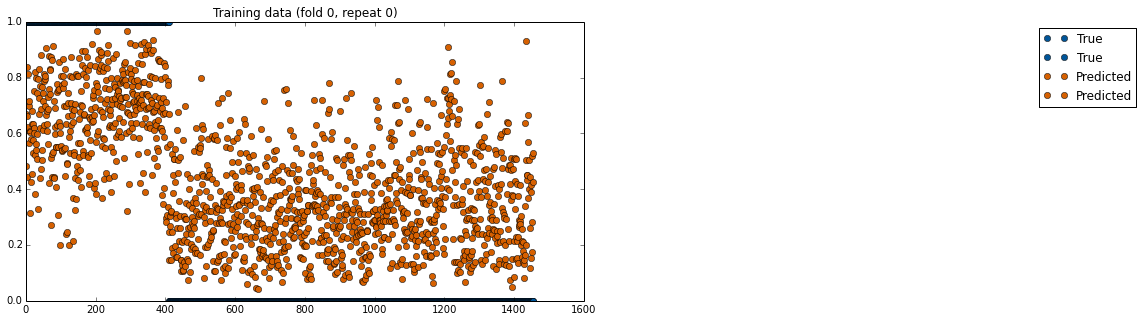

In [43]:
ix = clf.classes_.tolist().index(1)
tr_pos_indices = np.where(icv.y_tr > 0)[0]
tr_neg_indices = np.where(icv.y_tr == 0)[0]
#print len(tr_pos_indices), len(tr_neg_indices)

plt.figure(figsize=(10, 5))
plt.plot(range(len(tr_pos_indices)), icv.y_tr[tr_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), icv.y_tr[tr_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(tr_pos_indices)), ytr_pred[tr_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), ytr_pred[tr_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.title("Training data (fold 0, repeat 0)")
a = plt.legend(bbox_to_anchor=(1, 0, 1, 1))

436 selected features.


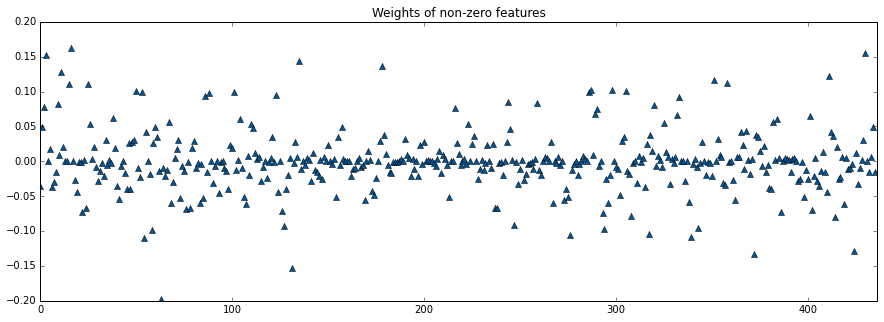

In [44]:
features = np.where(clf.coef_[0])[0]
print len(features), "selected features."

plt.figure(figsize=(15, 5))
plt.plot(range(len(features)), clf.coef_[0][features],
            color=blue_color, marker='^', ls='')
plt.title("Weights of non-zero features")
a = plt.xlim(-0.1, len(features)+0.1)

In [45]:
yte_pred = clf.predict_proba(icv.x_te)

45 116
Test AUC: 0.779118773946


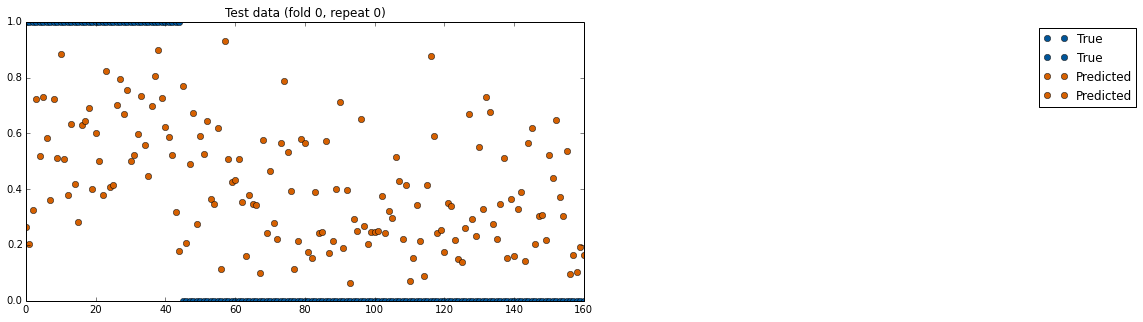

In [46]:
te_pos_indices = np.where(icv.y_te > 0)[0]
te_neg_indices = np.where(icv.y_te == 0)[0]
print len(te_pos_indices), len(te_neg_indices)
plt.figure(figsize=(10, 5))
plt.plot(range(len(te_pos_indices)), icv.y_te[te_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), icv.y_te[te_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(te_pos_indices)), yte_pred[te_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), yte_pred[te_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.title("Test data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))
print "Test AUC:", skm.roc_auc_score(icv.y_te, yte_pred[:, ix])

### With normalization

In [47]:
# Normalization
Xmean = np.mean(icv.x_tr, axis = 0)
Xstdv = np.std(icv.x_tr, axis = 0, ddof = 1)

Xtr_norm = (icv.x_tr - Xmean)/Xstdv
Xte_norm = (icv.x_te - Xmean)/Xstdv

(1455, 45068)


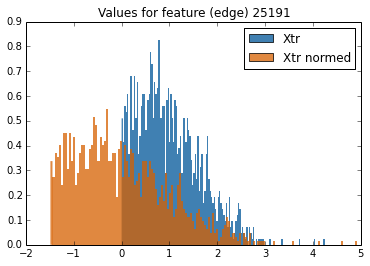

In [48]:
print icv.x_tr.shape
edge_idx=np.random.choice(np.arange(Xtr_norm.shape[1]))
a = plt.hist(icv.x_tr[:, edge_idx], normed=True, bins=150, edgecolor='none', 
            color=blue_color, alpha=0.75, label="Xtr")
a = plt.hist(Xtr_norm[:, edge_idx], normed=True, bins=150, edgecolor='none', 
            color=orange_color, alpha=0.75, label="Xtr normed")
plt.title("Values for feature (edge) %d" % edge_idx)
leg = plt.legend() 

In [50]:
cvClassif.fit(Xtr_norm, icv.y_tr)

LogisticRegressionCV(Cs=[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125],
           class_weight='balanced', cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring='roc_auc', solver='liblinear', tol=0.0001,
           verbose=0)

In [51]:
print cvClassif.C_

[ 0.03125]


In [52]:
optimalC = cvClassif.C_[0]
clf = sklm.LogisticRegression(C=optimalC, penalty='l1', solver='liblinear',
                              class_weight='balanced')
clf.fit(Xtr_norm, icv.y_tr)

LogisticRegression(C=0.03125, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [53]:
ytr_pred = clf.predict_proba(Xtr_norm)

410 1045


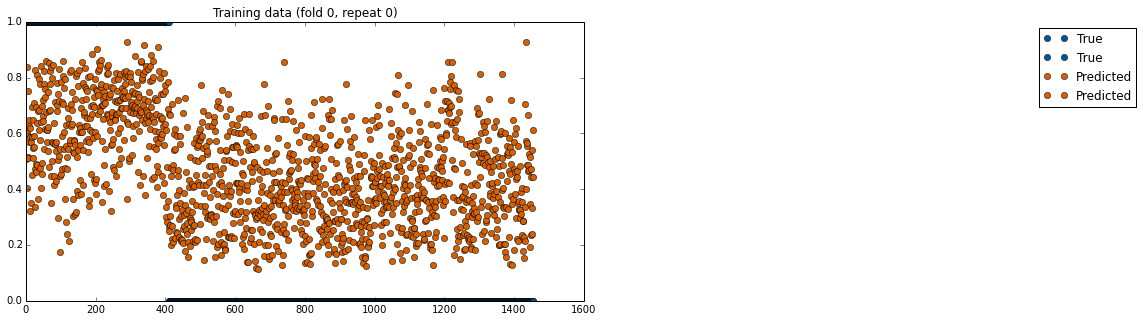

In [54]:
ix = clf.classes_.tolist().index(1)
tr_pos_indices = np.where(icv.y_tr > 0)[0]
tr_neg_indices = np.where(icv.y_tr == 0)[0]
print len(tr_pos_indices), len(tr_neg_indices)

plt.figure(figsize=(10, 5))
plt.plot(range(len(tr_pos_indices)), icv.y_tr[tr_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), icv.y_tr[tr_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(tr_pos_indices)), ytr_pred[tr_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), ytr_pred[tr_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.title("Training data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))

219 selected features


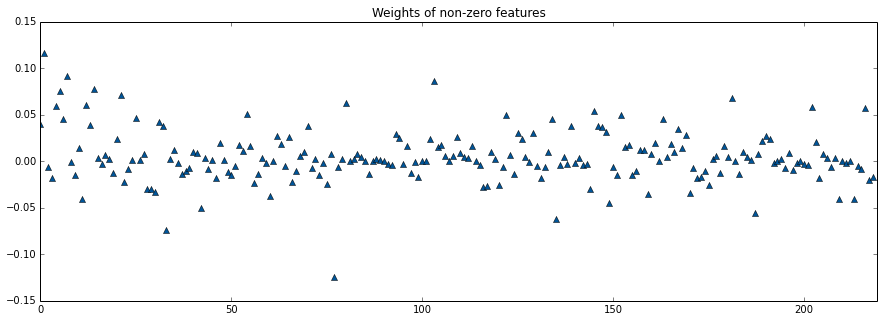

In [58]:
features = np.where(clf.coef_[0])[0]
print len(features), "selected features"

plt.figure(figsize=(15, 5))
plt.plot(range(len(features)), clf.coef_[0][features],
            color=blue_color, marker='^', ls='')
plt.title("Weights of non-zero features")
a = plt.xlim(-0.1, len(features)+0.1)

In [59]:
yte_pred = clf.predict_proba(Xte_norm)

45 116
Test AUC: 0.784482758621


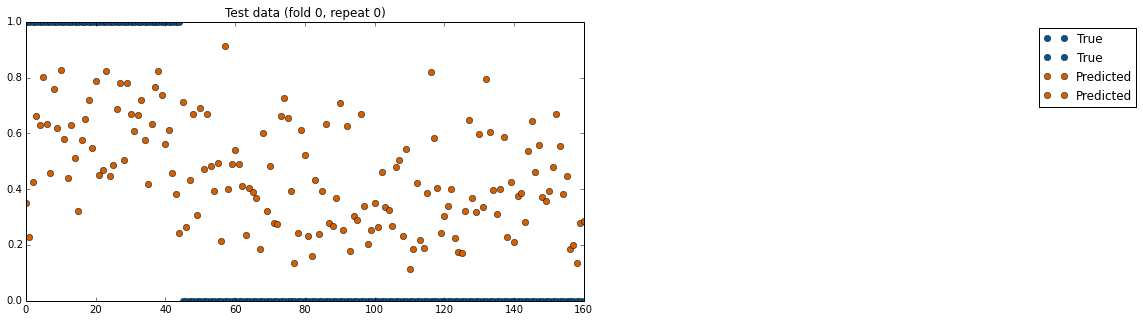

In [60]:
te_pos_indices = np.where(icv.y_te > 0)[0]
te_neg_indices = np.where(icv.y_te == 0)[0]
print len(te_pos_indices), len(te_neg_indices)

plt.figure(figsize=(10, 5))
plt.plot(range(len(te_pos_indices)), icv.y_te[te_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), icv.y_te[te_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(te_pos_indices)), yte_pred[te_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), yte_pred[te_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.title("Test data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))
print "Test AUC:", skm.roc_auc_score(icv.y_te, yte_pred[:, ix])

# Using node weights (gene expression data) as feature
## L1-regularized logistic regression

In [61]:
# L1-regularized logistic regression directly on gene expression data
sys.path.append('ACES')
from datatypes.ExpressionDataset import HDF5GroupToExpressionDataset

f = h5py.File("ACES/experiments/data/U133A_combat.h5")
acesData = HDF5GroupToExpressionDataset(f['U133A_combat_RFS'], checkNormalise=False)
f.close()

Z = acesData.expressionData

NOTE: HDF5GroupToExpressionDataset -- read ExpressionDataSet("U133A_combat_RFS"; 12750 genes; 1616 patients (good outcome: 1161 (71.84 %), bad outcome: 455 (28.16 %)))


In [63]:
trIndices = np.loadtxt('%s/train.indices' % data_dir, dtype='int')
teIndices = np.loadtxt('%s/test.indices' % data_dir, dtype='int')

Ztr = Z[trIndices, :]
Zte = Z[teIndices, :]

In [64]:
# Normalization
Zmean = np.mean(Ztr, axis = 0)
Zstdv = np.std(Ztr, axis = 0, ddof = 1)

Ztr_norm = (Ztr - Zmean)/Zstdv
Zte_norm = (Zte - Zmean)/Zstdv

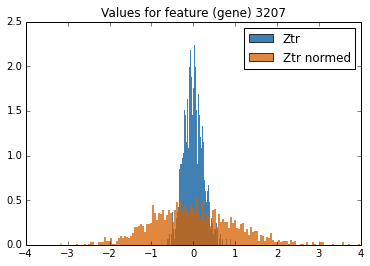

In [65]:
node_idx = np.random.choice(np.arange(Ztr_norm.shape[1]))
a = plt.hist(Ztr[:, node_idx], normed=True, bins=150, edgecolor='none', 
             color=blue_color, alpha=0.75, label="Ztr")
a = plt.hist(Ztr_norm[:, node_idx], normed=True, bins=150, edgecolor='none', 
             color=orange_color, alpha=0.75, label="Ztr normed")
plt.title("Values for feature (gene) %d" % node_idx)
leg = plt.legend() 

In [66]:
regParams = [2.**k for k in range(-8, -2)]
cvClassif = sklm.LogisticRegressionCV(Cs=regParams, penalty='l1', solver='liblinear',
                                     class_weight='balanced', scoring='roc_auc')

In [67]:
cvClassif.fit(Ztr_norm, icv.y_tr)

LogisticRegressionCV(Cs=[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125],
           class_weight='balanced', cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring='roc_auc', solver='liblinear', tol=0.0001,
           verbose=0)

In [68]:
print cvClassif.C_

[ 0.0625]


In [69]:
optimalC = cvClassif.C_[0]
clf = sklm.LogisticRegression(C=optimalC, penalty='l1', solver='liblinear',
                              class_weight='balanced')
clf.fit(Ztr_norm, icv.y_tr)

LogisticRegression(C=0.0625, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [70]:
ytr_pred = clf.predict_proba(Ztr_norm)

410 1045


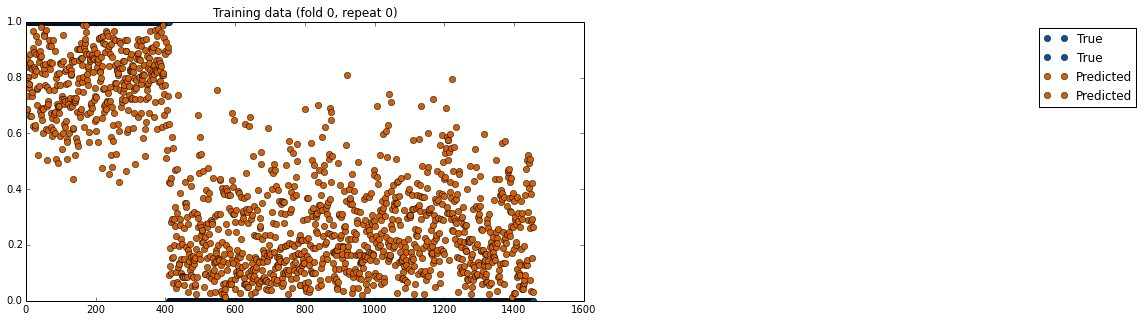

In [71]:
ix = clf.classes_.tolist().index(1)
tr_pos_indices = np.where(icv.y_tr > 0)[0]
tr_neg_indices = np.where(icv.y_tr == 0)[0]
print len(tr_pos_indices), len(tr_neg_indices)

plt.figure(figsize=(10, 5))
plt.plot(range(len(tr_pos_indices)), icv.y_tr[tr_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), icv.y_tr[tr_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(tr_pos_indices)), ytr_pred[tr_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), ytr_pred[tr_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.title("Training data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))

449 selected features.


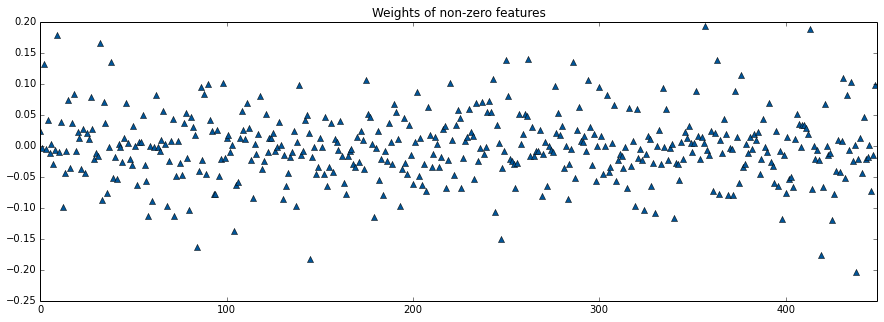

In [73]:
features = np.where(clf.coef_[0])[0]
print len(features), "selected features."

plt.figure(figsize=(15, 5))
plt.plot(range(len(features)), clf.coef_[0][features],
            color=blue_color, marker='^', ls='')
plt.title("Weights of non-zero features")
a = plt.xlim(-0.1, len(features)+0.1)

In [74]:
yte_pred = clf.predict_proba(Zte_norm)

45 116
Test AUC: 0.742337164751


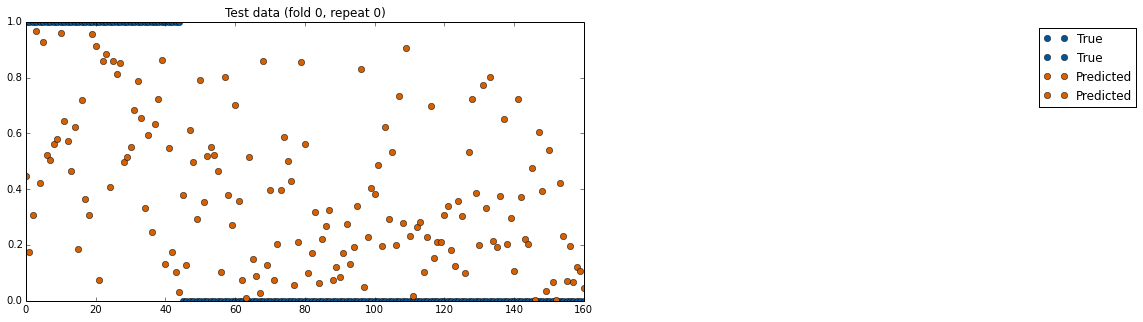

In [75]:
te_pos_indices = np.where(icv.y_te > 0)[0]
te_neg_indices = np.where(icv.y_te == 0)[0]
print len(te_pos_indices), len(te_neg_indices)

plt.figure(figsize=(10, 5))
plt.plot(range(len(te_pos_indices)), icv.y_te[te_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), icv.y_te[te_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(te_pos_indices)), yte_pred[te_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), yte_pred[te_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.title("Test data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))
print "Test AUC:", skm.roc_auc_score(icv.y_te, yte_pred[:, ix])

## Elastic Net 

In [ ]:
print [2.**k for k in range(-8, -2)]
print [2.**k for k in range(-6, -3)]

In [ ]:
# Grid search Elastic Net (for classification)
#alpha_values = [2.**k for k in range(-8, -2)]
l1_ratio_values = [.1, .5, .7, .9, .95, .99]
#l1_ratio_values = [float(k+1)/7 for k in range(6)]

#lbd_values = [2.**k for k in range(-6, -3)] #[2.**k for k in range(-8, -2)]
lbd_values = [10.**k for k in range(-7, -2)]

auc_dict = {} # auc:params

cross_validator = skcv.StratifiedKFold(icv.Ytr, 5)

# for alpha in alpha_values:
for lbd in lbd_values:
     for l1_ratio in l1_ratio_values:
        alpha = lbd / l1_ratio

        clf = sklm.SGDClassifier(loss='log', penalty='elasticnet', alpha=alpha, l1_ratio=l1_ratio)
        y_true = []
        y_pred = []
        for tr, te in cross_validator:
            clf.fit(icv.Xtr[tr, :], icv.Ytr[tr])
            ytr_te_pred = clf.predict_proba(icv.Xtr[te, :])
            ix = clf.classes_.tolist().index(1)
            y_pred.extend(ytr_te_pred[:, ix])
            y_true.extend(icv.Ytr[te])            
            
        auc = skm.roc_auc_score(y_true, y_pred)
        print "alpha", alpha, "\tl1_ratio", l1_ratio, "\tauc", auc
        if not auc_dict.has_key(auc):
            auc_dict[auc] = []
        auc_dict[auc].append([alpha, l1_ratio])

auc_values = auc_dict.keys()
auc_values.sort()
best_auc = auc_values[-1]
print "Best AUC: ", best_auc

print auc_dict[best_auc]               

In [ ]:
# Run Elastic Net
alpha = auc_dict[best_auc][0][0]
l1_ratio = auc_dict[best_auc][0][1]

clf = sklm.SGDClassifier(loss='log', penalty='elasticnet', alpha=alpha, l1_ratio=l1_ratio)

clf.fit(icv.Xtr, icv.Ytr)
ytr_pred = clf.predict_proba(icv.Xtr)

ix = clf.classes_.tolist().index(1)
tr_pos_indices = np.where(icv.Ytr > 0)[0]
tr_neg_indices = np.where(icv.Ytr == 0)[0]
print len(tr_pos_indices), len(tr_neg_indices)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(tr_pos_indices)), icv.Ytr[tr_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), icv.Ytr[tr_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(tr_pos_indices)), ytr_pred[tr_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='+', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), ytr_pred[tr_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='+', ls='')
plt.title("Training data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))

In [ ]:
features = np.where(clf.coef_[0])[0]
print len(features), "selected features"
plt.figure(figsize=(15, 5))
plt.plot(range(len(features)), clf.coef_[0][features],
            color=blue_color, marker='+', ls='')

In [ ]:
yte_pred = clf.predict_proba(icv.Xte)
te_pos_indices = np.where(icv.Yte > 0)[0]
te_neg_indices = np.where(icv.Yte == 0)[0]
print len(te_pos_indices), len(te_neg_indices)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(te_pos_indices)), icv.Yte[te_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), icv.Yte[te_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(te_pos_indices)), yte_pred[te_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='+', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), yte_pred[te_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='+', ls='')
plt.title("Test data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))
print "AUC:", skm.roc_auc_score(icv.Yte, yte_pred[:, ix])